In [1]:
%cd ..

/Users/jason/repos/diffusion-motion-inbetweening


In [2]:
import warnings
from pathlib import Path

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

warnings.filterwarnings("once")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# %matplotlib --list
# %matplotlib qt6

In [4]:
results_path = Path(
    "save/results/condmdi_random_joints/condsamples000750000__imputation_benchmark_clip_T=40_CI=0_CRG=0_KGP=1.0_seed10_person_throwing_a_ball/results.npy"
)


In [5]:
results = np.load(results_path, allow_pickle=True).item()

In [6]:
for key, value in results.items():
    if type(value) == np.ndarray:
        print(f"'{key}' shape: {value.shape}")
    else:
        print(f"'{key}' value: {value}")

'sample' shape: (3, 1, 1, 196, 263)
'motion' shape: (3, 1, 22, 3, 196)
'text' shape: (3,)
'lengths' shape: (3, 1)
'num_samples' value: 1
'num_repetitions' value: 3
'observed_motion' shape: (1, 22, 3, 196)
'observed_mask' shape: (1, 22, 1, 196)
'pre_y' value: -0.03444706425401248
'pre_xz' shape: (3,)
'pre_rot' shape: (196, 22, 4)


## Numpy Format

| Key | Shape |
| --- | --- |
| `motion` | `[num_rep, num_samples, 22, 3, n_frames]` |
| `observed_motion` | `[num_samples, 22, 3, n_frames]` |
| `observed_mask` | `[num_samples, 22, 1, n_frames]` |
| `lengths` | `[num_rep, num_samples]` |
| `text` | `[num_rep, num_samples]` |

where
- `num_rep = 3`
- `num_samples = 10`
- `n_frames = 196` (maximum is 196, can be lower)
- `n_joints = 22` (smpl joints)


In [7]:
from data_loaders.humanml.utils.paramUtil import t2m_kinematic_chain, t2m_raw_offsets

In [8]:
samples = results["sample"]
sampled_motions = results["motion"][:, 0].transpose(0, 3, 1, 2)
observed_mask = results["observed_mask"][0]
observed_motion = results["observed_motion"][0].transpose(2,0,1)

num_samples = sampled_motions.shape[0]

print(sampled_motions.shape, observed_mask.shape, observed_motion.shape)

(3, 196, 22, 3) (22, 1, 196) (196, 22, 3)


In [9]:
def plot_mask(name, feat_mask):
    plt.figure(figsize=(8, 6))
    plt.suptitle(name)
    sns.heatmap(feat_mask[:, 0, :], cmap="viridis", cbar=False)
    plt.xlabel("Frames")
    plt.ylabel("Joints")
    plt.tight_layout()
    plt.show()

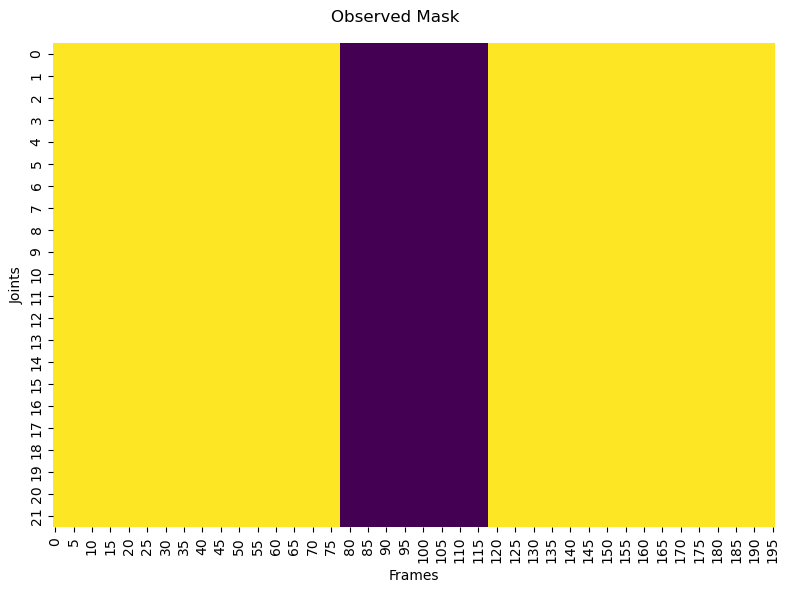

In [10]:
plot_mask("Observed Mask", observed_mask)

In [11]:
# Get frames, where the mask for root is 0
np.argwhere(observed_mask[0, 0, :] == 0).flatten()

array([ 78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117])

In [12]:
@ipywidgets.interact(frame=(0, 195))
def plot(frame=78):
    fig = plt.figure(figsize=(9, 9))
    plt.suptitle(f"{results_path.parent.name}\nGT: Orange\n Samples: Other colors")

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.view_init(elev=10, azim=25, vertical_axis="y")
    ax.axis("equal")

    ax.set_ylim(0, 2)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)

    colors = ["cyan", "lightblue", "lightgreen"]

    for i, col in enumerate(colors):
        for chain in t2m_kinematic_chain:
            ax.plot3D(
                sampled_motions[i, frame, chain, 0],
                sampled_motions[i, frame, chain, 1],
                sampled_motions[i, frame, chain, 2],
                color=col,
            )

    for chain in t2m_kinematic_chain:
        ax.plot3D(
            observed_motion[frame, chain, 0],
            observed_motion[frame, chain, 1],
            observed_motion[frame, chain, 2],
            color="orange",
        )

    plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/condmdi/lib/python3.9/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(IntSlider(value=78, description='frame', max=195), Output()), _dom_classes=('widget-inte…

---

## Comparing the two `recover_from` functions

In [13]:
import torch
from data_loaders.humanml.common.skeleton import Skeleton
from data_loaders.humanml.scripts.motion_process import (
    recover_from_ric,
    recover_from_rot,
    recover_root_rot_pos,
)

/Users/jason/repos/diffusion-motion-inbetweening/data_loaders/humanml/common/quaternion.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _FLOAT_EPS = np.finfo(np.float).eps


In [14]:
samples.shape, samples.squeeze(1).shape

((3, 1, 1, 196, 263), (3, 1, 196, 263))

In [15]:
motion_from_ric = recover_from_ric(torch.from_numpy(samples.squeeze(1)), 22, abs_3d=True)
motion_from_ric = motion_from_ric.squeeze(1)
motion_from_ric.shape

torch.Size([3, 196, 22, 3])

In [16]:
example_data = np.load("dataset/000021.npy")
example_data = example_data.reshape(len(example_data), -1, 3)
example_data = torch.from_numpy(example_data)

tgt_skel = Skeleton(torch.from_numpy(t2m_raw_offsets), t2m_kinematic_chain, "cpu")
tgt_offsets = tgt_skel.get_offsets_joints(example_data[0])

In [17]:
motion_from_rot = []
for sample in samples:
    my_skel = Skeleton(
        torch.from_numpy(t2m_raw_offsets), t2m_kinematic_chain, "cpu"
    )
    my_skel.set_offset(tgt_offsets)

    _motion_from_rot = recover_from_rot(
        torch.from_numpy(sample), 22, my_skel, abs_3d=True
    )
    _motion_from_rot = _motion_from_rot.squeeze(1)
    motion_from_rot.append(_motion_from_rot)

motion_from_rot = torch.stack(motion_from_rot)
print(motion_from_rot.shape)

torch.Size([3, 196, 22, 3])


In [18]:
@ipywidgets.interact(frame=(0, 195))
def plot(frame=78):
    fig = plt.figure(figsize=(9, 9))
    plt.suptitle(f"{results_path.parent.name}\nBlue: from_ric\nRed: from_rot\nGreen: GT")

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.view_init(elev=10, azim=25, vertical_axis="y")
    ax.axis("equal")

    ax.set_ylim(0, 2)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)


    for i in range(motion_from_ric.shape[0]):
        for chain in t2m_kinematic_chain:
            ax.plot3D(
                motion_from_ric[i, frame, chain, 0],
                motion_from_ric[i, frame, chain, 1],
                motion_from_ric[i, frame, chain, 2],
                color="blue",
                alpha=0.5,
            )
            ax.plot3D(
                motion_from_rot[i, frame, chain, 0],
                motion_from_rot[i, frame, chain, 1],
                motion_from_rot[i, frame, chain, 2],
                color="red",
                alpha=0.5,
            )

    for chain in t2m_kinematic_chain:
        ax.plot3D(
            observed_motion[frame, chain, 0],
            observed_motion[frame, chain, 1],
            observed_motion[frame, chain, 2],
            color="green",
            alpha=0.5,
        )

    plt.show()

interactive(children=(IntSlider(value=78, description='frame', max=195), Output()), _dom_classes=('widget-inte…

## Positional Data seems to (mostly) match, what about rotational?

In [19]:
from data_loaders.humanml.common.quaternion import (
    cont6d_to_matrix,
    qinv,
    qrot,
    quaternion_to_cont6d,
    quaternion_to_matrix,
)
from scipy.spatial.transform import Rotation as R

face_joint_indx = [2, 1, 17, 16]

In [20]:

def recover_cont6d_from_rot(data, joints_num, abs_3d=False):
    r_rot_quat, r_pos = recover_root_rot_pos(data, abs_3d=abs_3d)

    r_rot_cont6d = quaternion_to_cont6d(r_rot_quat)

    start_indx = 1 + 2 + 1 + (joints_num - 1) * 3
    end_indx = start_indx + (joints_num - 1) * 6
    cont6d_params = data[..., start_indx:end_indx]
    #     print(r_rot_cont6d.shape, cont6d_params.shape, r_pos.shape)
    cont6d_params = torch.cat([r_rot_cont6d, cont6d_params], dim=-1)
    cont6d_params = cont6d_params.view(-1, joints_num, 6)

    # positions = skeleton.forward_kinematics_cont6d(cont6d_params, r_pos)

    return cont6d_params

def recover_quat_from_rot(data, joints_num, abs_3d=False):
    r_rot_quat, r_pos = recover_root_rot_pos(data, abs_3d=abs_3d)

    r_rot_cont6d = quaternion_to_cont6d(r_rot_quat)

    start_indx = 1 + 2 + 1 + (joints_num - 1) * 3
    end_indx = start_indx + (joints_num - 1) * 6
    cont6d_params = data[..., start_indx:end_indx]
    #     print(r_rot_cont6d.shape, cont6d_params.shape, r_pos.shape)
    cont6d_params = torch.cat([r_rot_cont6d, cont6d_params], dim=-1)
    cont6d_params = cont6d_params.view(-1, joints_num, 6)

    mat_params = cont6d_to_matrix(cont6d_params)

    quat_params = []
    for i in range(mat_params.shape[0]):
        # scipy quat is scalar-last aka xyzw
        # therefore we need to convert to wxyz
        quat_params.append(R.from_matrix(mat_params[i].numpy()).as_quat()[..., [3, 0, 1, 2]])

    quat_params = torch.from_numpy(np.stack(quat_params)).float()
    return quat_params

In [21]:
def recover_cont6d_from_ric(data, joints_num, skeleton: Skeleton, abs_3d=False):
    r_rot_quat, r_pos = recover_root_rot_pos(data, abs_3d=abs_3d)
    positions = data[..., 4:(joints_num - 1) * 3 + 4]
    positions = positions.view(positions.shape[:-1] + (-1, 3))

    '''Add Y-axis rotation to local joints'''
    positions = qrot(qinv(r_rot_quat[..., None, :]).expand(positions.shape[:-1] + (4,)), positions)

    '''Add root XZ to joints'''
    positions[..., 0] += r_pos[..., 0:1]
    positions[..., 2] += r_pos[..., 2:3]

    '''Concate root and joints'''
    positions = torch.cat([r_pos.unsqueeze(-2), positions], dim=-2)

    quat_params = skeleton.inverse_kinematics_np(positions.numpy(), face_joint_indx, fixed=True)
    cont6d_params = quaternion_to_cont6d(torch.from_numpy(quat_params))

    return cont6d_params.float()

def recover_quat_from_ric(data, joints_num, skeleton: Skeleton, abs_3d=False):
    r_rot_quat, r_pos = recover_root_rot_pos(data, abs_3d=abs_3d)
    positions = data[..., 4:(joints_num - 1) * 3 + 4]
    positions = positions.view(positions.shape[:-1] + (-1, 3))

    '''Add Y-axis rotation to local joints'''
    positions = qrot(qinv(r_rot_quat[..., None, :]).expand(positions.shape[:-1] + (4,)), positions)

    '''Add root XZ to joints'''
    positions[..., 0] += r_pos[..., 0:1]
    positions[..., 2] += r_pos[..., 2:3]

    '''Concate root and joints'''
    positions = torch.cat([r_pos.unsqueeze(-2), positions], dim=-2)

    quat_params = skeleton.inverse_kinematics_np(positions.numpy(), face_joint_indx, fixed=True)

    return torch.from_numpy(quat_params).float()

In [22]:
cont6d_from_rot = recover_cont6d_from_rot(torch.from_numpy(samples[0,0,0]), 22, abs_3d=True)
cont6d_from_rot.shape, cont6d_from_rot.dtype

(torch.Size([196, 22, 6]), torch.float32)

In [23]:
cont6d_from_ric = recover_cont6d_from_ric(torch.from_numpy(samples[0,0,0]), 22, my_skel, abs_3d=True)
cont6d_from_ric.shape, cont6d_from_ric.dtype

/Users/jason/repos/diffusion-motion-inbetweening/data_loaders/humanml/common/skeleton.py:72: RuntimeWarning: invalid value encountered in true_divide
  across = across / np.sqrt((across**2).sum(axis=-1))[:, np.newaxis]


(torch.Size([196, 22, 6]), torch.float32)

In [24]:
quat_from_rot = recover_quat_from_rot(torch.from_numpy(samples[0,0,0]), 22, abs_3d=True)
quat_from_rot.shape, quat_from_rot.dtype

(torch.Size([196, 22, 4]), torch.float32)

In [25]:
quat_from_ric = recover_quat_from_ric(torch.from_numpy(samples[0,0,0]), 22, my_skel, abs_3d=True)
quat_from_ric.shape, quat_from_ric.dtype

(torch.Size([196, 22, 4]), torch.float32)

In [26]:
mat_from_ric1 = cont6d_to_matrix(cont6d_from_ric)
mat_from_ric2 = quaternion_to_matrix(quat_from_ric)
ric1 = R.from_matrix(mat_from_ric1[0].numpy())
ric2 = R.from_matrix(mat_from_ric2[0].numpy())
print(list(zip(ric1.as_euler("xyz", degrees=True).tolist(), ric2.as_euler("xyz", degrees=True).tolist())))
np.allclose(ric1.as_euler("xyz", degrees=True), ric2.as_euler("xyz", degrees=True))

[([0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), ([-2.0026043429129485, 3.8455111668624076, -55.00492531828772], [-2.0026044856835026, 3.8455113141430046, -55.00492368364188]), ([1.369639730898498, 2.8510929734480905, 51.31133602019141], [1.3696396695741742, 2.8510927904103363, 51.31133259877846]), ([-16.490429240051007, 0.09329476806669626, 0.6438148834889874], [-16.4904297348736, 0.09329478029762106, 0.6438149013069814]), ([-1.540482900694418, -3.814664282292471, 56.00447472875532], [-1.540482442412554, -3.8146638513906934, 56.004466158943615]), ([-23.35297506798283, -4.186111062858534, -58.18929218150684], [-23.35297344623169, -4.186110307373671, -58.18929135852491]), ([18.447012627809418, 0.27307323369734604, -1.2150844874772109], [18.447011474494502, 0.2730732389337858, -1.21508458274133]), ([17.017383703667115, 1.2462262126990848, -9.614756125468867], [17.017384801851318, 1.2462263866678434, -9.614756673420732]), ([25.22890836835678, 0.5789005495790518, 2.3602649053947777], [25.2289078939558

True

In [27]:
mat_from_rot1 = cont6d_to_matrix(cont6d_from_rot)  # cont6d -> matrix
mat_from_rot2 = quaternion_to_matrix(quat_from_rot)  # cont6d -> matrix -> quat -> matrix
rot1 = R.from_matrix(mat_from_rot1[0].numpy())
rot2 = R.from_matrix(mat_from_rot2[0].numpy())

print(list(zip(rot1.as_euler("xyz", degrees=True).tolist(), rot2.as_euler("xyz", degrees=False).tolist())))
np.allclose(rot1.as_euler("xyz", degrees=True), rot2.as_euler("xyz", degrees=True))

[([0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), ([-2.0026045531316043, 3.8455114543335855, -55.00492355240783], [-0.03495204578126453, 0.06711684130051987, -0.9600170233487061]), ([1.3696398014907818, 2.8510926224707136, 51.31133095973325], [0.023904721880875016, 0.04976095181237161, 0.8955516234162927]), ([-16.49042924001432, 0.09329477473680287, 0.6438148825224653], [-0.2878122939438364, 0.0016283009561663953, 0.011236688869884132]), ([-1.5404826480023102, -3.814664046616155, 56.00446766489244], [-0.026886494426786187, -0.06657844917831746, 0.9774623426172392]), ([-23.35297506798283, -4.186111062858534, -58.18929218150684], [-0.4075863316782494, -0.0730614293795222, -1.015594734656839]), ([18.44701092002432, 0.2730732362616746, -1.2150844912377945], [0.3219610527466724, 0.004766026622060604, -0.02120722457641588]), ([17.017385414063465, 1.246226213637132, -9.614756979293992], [0.29700939490566397, 0.02175075123067649, -0.1678091763307123]), ([25.228909128707794, 0.5789004838031836, 2.3602644041

True

In [28]:
mat_from_rot3 = []
for f in range(195):
    _mat = R.from_quat(quat_from_rot[f].numpy()).as_matrix()
    mat_from_rot3.append(_mat)
mat_from_rot3 = torch.tensor(np.stack(mat_from_rot3))
rot3 = R.from_matrix(mat_from_rot3[0].numpy())

np.allclose(rot1.as_euler("xyz", degrees=True), rot3.as_euler("xyz", degrees=True))

False

In [29]:
np.allclose(rot1.as_euler("xyz", degrees=True), ric1.as_euler("xyz", degrees=True))

False

In [30]:
np.allclose(rot2.as_euler("xyz", degrees=True), ric2.as_euler("xyz", degrees=True))

False

In [31]:
from data_loaders.humanml.common.quaternion import quaternion_to_matrix_np

for i in range(30):
    # NOTE: scipy uses scalar-last `xyzw` format for quaternions
    #       while this repo uses the `wxyz` format
    test_quat = R.random().as_quat()
    test_cont6d = quaternion_to_cont6d(torch.from_numpy(test_quat[..., [3, 0, 1, 2]]))

    test_mat1 = R.from_quat(test_quat).as_matrix()
    # test_mat2 = quaternion_to_matrix_np(test_quat)
    test_mat3 = quaternion_to_matrix_np(test_quat[..., [3, 0, 1, 2]])
    test_mat4 = cont6d_to_matrix(test_cont6d).numpy()
    try:
        # assert np.allclose(test_mat1, test_mat2)
        assert np.allclose(test_mat1, test_mat3), f"test_mat1 != test_mat3"
        assert np.allclose(test_mat1, test_mat4), f"test_mat1 != test_mat4"
    except AssertionError as e:
        print(e)
        print(test_quat)
        print(test_cont6d)
        print("test_mat1:")
        print(test_mat1)
        # print("test_mat2:")
        # print(test_mat2)
        print("test_mat3:")
        print(test_mat3)
        print("test_mat4:")
        print(test_mat4)


---

## Try exporting those rotations as BVH and see if they match

- Take Root Position from above
- Export once with `from_ric` and once `from_rot`

---

In [32]:
from convert.joints2bvh import BVH, Animation
from convert.joints2bvh.Quaternions import Quaternions


def convert(root_pos, rotations, filename):

    re_order = [0, 1, 4, 7, 10, 2, 5, 8, 11, 3, 6, 9, 12, 15, 13, 16, 18, 20, 14, 17, 19, 21]
    re_order_inv = [0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 14, 18, 13, 15, 19, 16, 20, 17, 21]

    new_anim = BVH.load("convert/joints2bvh/data/template.bvh", need_quater=True)
    new_anim.positions = new_anim.positions[0:1].repeat(rotations.shape[0], axis=-0)
    new_anim.positions[:, 0] = root_pos
    new_anim.rotations = Quaternions(rotations[:, re_order])

    BVH.save(filename, new_anim, names=new_anim.names, frametime=1 / 20, order='zyx', quater=True)
    glb = Animation.positions_global(new_anim)[:, re_order_inv]
    return new_anim, glb

In [33]:
_, r_pos = recover_root_rot_pos(torch.from_numpy(samples), abs_3d=True)
r_pos.shape

torch.Size([3, 1, 1, 196, 3])

In [34]:
anim_from_rot, glb_from_rot = convert(
    r_pos[0, 0, 0, :-1].numpy(),
    quat_from_rot[:-1].numpy(),
    f"test_from_rot.bvh"
)

In [35]:
anim_from_ric, glb_from_ric = convert(
    r_pos[0, 0, 0, :-1].numpy(),
    quat_from_ric[:-1].numpy(),
    f"test_from_ric.bvh"
)

interactive(children=(IntSlider(value=78, description='frame', max=195), Output()), _dom_classes=('widget-inte…

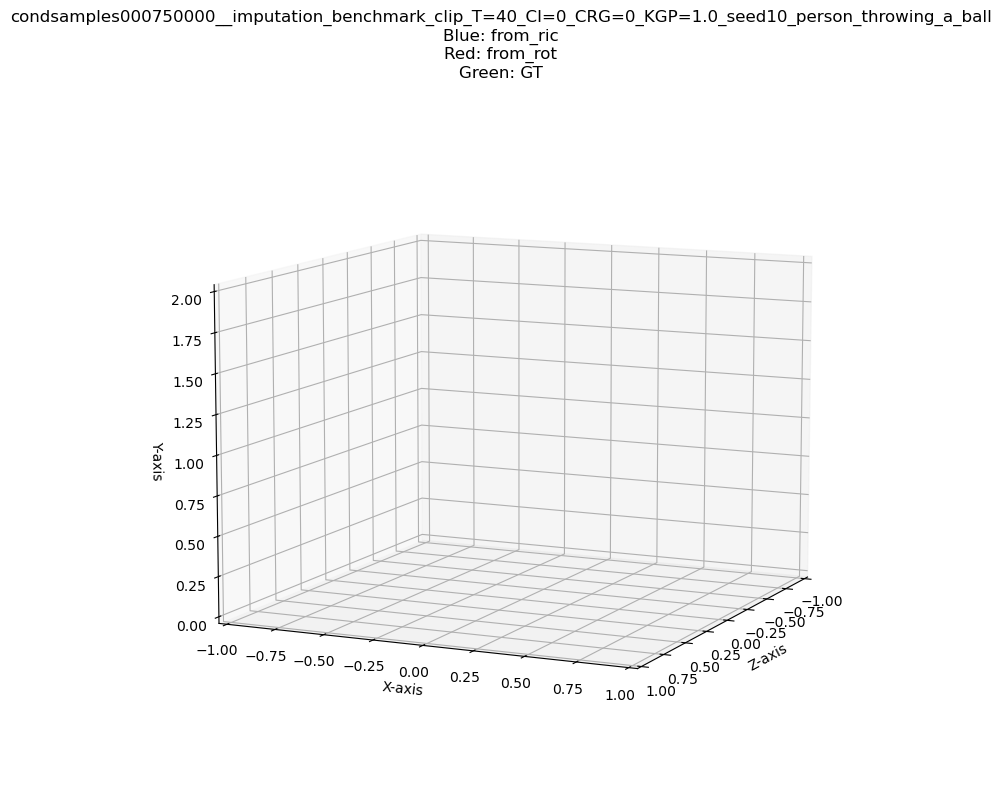

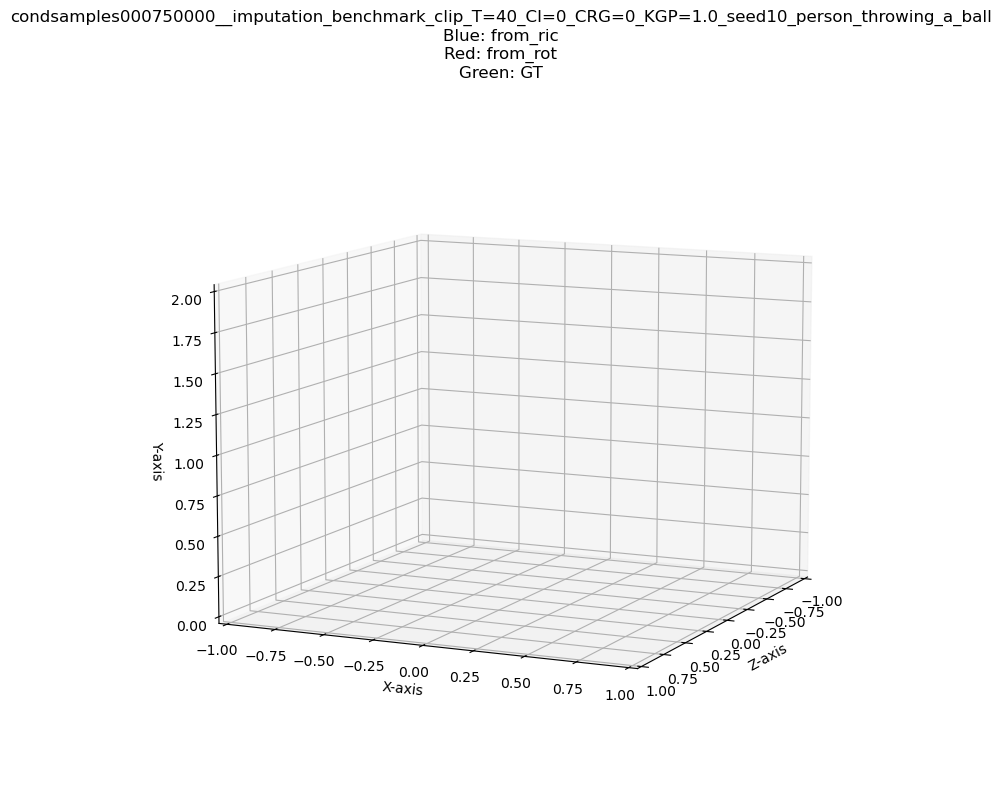

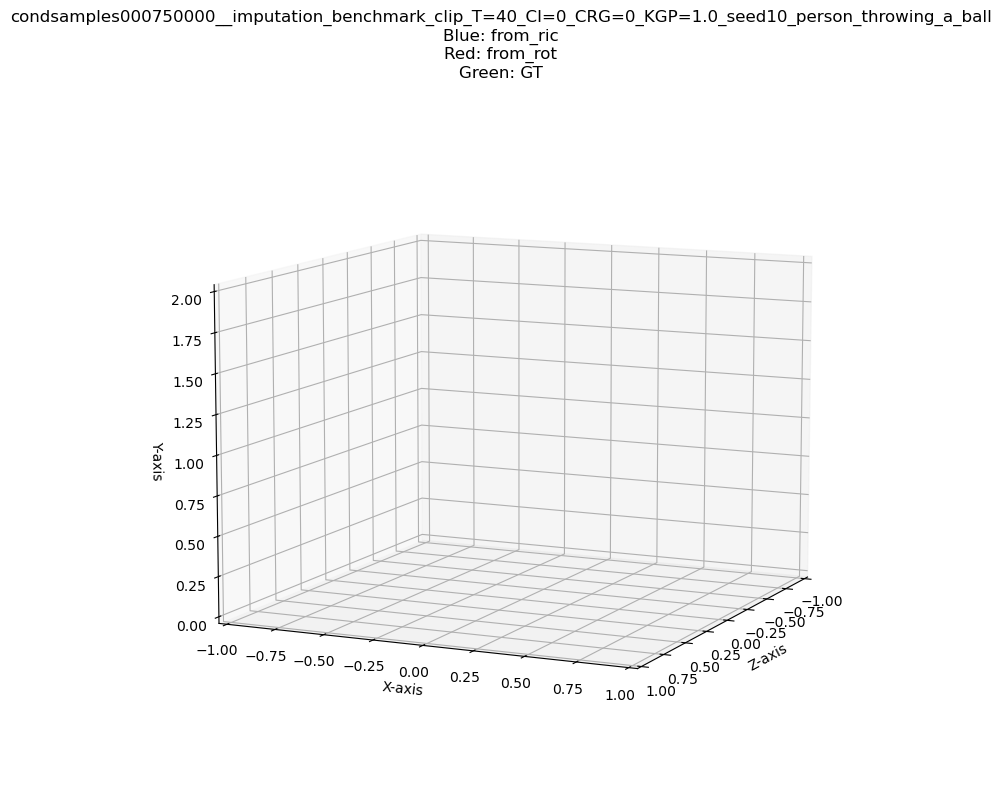

In [36]:
@ipywidgets.interact(frame=(0, 195))
def plot(frame=78):
    fig = plt.figure(figsize=(9, 9))
    plt.suptitle(f"{results_path.parent.name}\nBlue: from_ric\nRed: from_rot\nGreen: GT")

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.view_init(elev=10, azim=25, vertical_axis="y")
    ax.axis("equal")

    ax.set_ylim(0, 2)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)

    for chain in t2m_kinematic_chain:
        ax.plot3D(
            glb_from_ric[frame, chain, 0],
            glb_from_ric[frame, chain, 1],
            glb_from_ric[frame, chain, 2],
            color="blue",
            alpha=0.5,
        )
        ax.plot3D(
            glb_from_rot[frame, chain, 0],
            glb_from_rot[frame, chain, 1],
            glb_from_rot[frame, chain, 2],
            color="red",
            alpha=0.5,
        )

    for chain in t2m_kinematic_chain:
        ax.plot3D(
            observed_motion[frame, chain, 0],
            observed_motion[frame, chain, 1],
            observed_motion[frame, chain, 2],
            color="green",
            alpha=0.5,
        )

    plt.show()

---

## Convert Combined
- Initialize with position
- Use Rotations for the rest

In [37]:
def convert_posrot_to_bvh(positions, rotations, filename):

    re_order = [0, 1, 4, 7, 10, 2, 5, 8, 11, 3, 6, 9, 12, 15, 13, 16, 18, 20, 14, 17, 19, 21]
    re_order_inv = [0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 14, 18, 13, 15, 19, 16, 20, 17, 21]

    new_anim = BVH.load("convert/joints2bvh/data/template.bvh", need_quater=True)
    new_anim.positions = new_anim.positions[0:1].repeat(rotations.shape[0], axis=-0)
    new_anim.positions[:, 0] = positions[:, 0]
    new_anim.rotations = Quaternions(rotations[:, re_order])

    # TODO: This makes no sense, our positions are global, be here we would need local positions
    # new_anim.positions = positions[:, re_order]



    BVH.save(filename, new_anim, names=new_anim.names, frametime=1 / 20, order='zyx', quater=True)
    glb = Animation.positions_global(new_anim)[:, re_order_inv]

    assert np.allclose(glb, positions)

    return new_anim, glb


In [38]:
def convert_to_bvh_using_skel_offsets(positions, rotations, filename):

    re_order = [0, 1, 4, 7, 10, 2, 5, 8, 11, 3, 6, 9, 12, 15, 13, 16, 18, 20, 14, 17, 19, 21]
    re_order_inv = [0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 14, 18, 13, 15, 19, 16, 20, 17, 21]

    template_anim = BVH.load("convert/joints2bvh/data/template.bvh", need_quater=True)
    names = [template_anim.names[i] for i in re_order_inv]
    # names = template_anim.names
    orients = template_anim.orients[re_order_inv]
    # orients = template_anim.orients
    parents = template_anim.parents[re_order_inv]
    # parents = template_anim.parents

    offsets = tgt_offsets

    new_anim = Animation.Animation(
        Quaternions(rotations),
        positions,
        orients,
        offsets,
        parents,
        names,
        frametime=1 / 20,
    )

    BVH.save(filename, new_anim, names=new_anim.names, frametime=1 / 20, order='zyx', quater=True)
    glb = Animation.positions_global(new_anim)[:, re_order]

    # assert np.allclose(glb, positions)

    return new_anim, glb


In [39]:
glb_from_ric.shape, quat_from_ric.shape

((195, 22, 3), torch.Size([196, 22, 4]))

In [40]:
r_pos[0, 0, 0, :-1].numpy().shape, quat_from_rot[:-1].numpy().shape,

((195, 3), (195, 22, 4))

In [41]:
posrot_skel_anim, posrot_skel_glb = convert_to_bvh_using_skel_offsets(
    r_pos[0, 0, :, :-1].numpy(),
    quat_from_rot[:-1].numpy(),
    f"test_posrot_skel.bvh"
)

/Users/jason/repos/diffusion-motion-inbetweening/convert/joints2bvh/BVH.py:113: DeprecationWarning: invalid escape sequence \s
  jmatch = re.match("\s*JOINT\s+(\w+:?\w+)", line)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
@ipywidgets.interact(frame=(0, 195))
def plot(frame=78):
    fig = plt.figure(figsize=(9, 9))
    plt.suptitle(f"{results_path.parent.name}\nBlue: posrot_skel\nGreen: GT")

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.view_init(elev=10, azim=25, vertical_axis="y")
    ax.axis("equal")

    ax.set_ylim(0, 2)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)

    for chain in t2m_kinematic_chain:
        ax.plot3D(
            posrot_skel_glb[frame, chain, 0],
            posrot_skel_glb[frame, chain, 1],
            posrot_skel_glb[frame, chain, 2],
            color="blue",
            alpha=0.5,
        )


    for chain in t2m_kinematic_chain:
        ax.plot3D(
            observed_motion[frame, chain, 0],
            observed_motion[frame, chain, 1],
            observed_motion[frame, chain, 2],
            color="green",
            alpha=0.5,
        )
    for joint_id in range(22):
        ax.text(
            posrot_skel_glb[frame, joint_id, 0],
            posrot_skel_glb[frame, joint_id, 1],
            posrot_skel_glb[frame, joint_id, 2],
            f"{joint_id} {posrot_anim.names[joint_id]}",
            color="black",
            fontsize=8,
        )


    plt.show()

interactive(children=(IntSlider(value=78, description='frame', max=195), Output()), _dom_classes=('widget-inte…

In [ ]:
posrot_anim, posrot_glb = convert_posrot_to_bvh(
    glb_from_ric,
    quat_from_ric[:-1].numpy(),
    f"test_posrot.bvh"
)

In [ ]:
@ipywidgets.interact(frame=(0, 195))
def plot(frame=78):
    fig = plt.figure(figsize=(9, 9))
    plt.suptitle(f"{results_path.parent.name}\nBlue: posrot\nGreen: GT")

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.view_init(elev=10, azim=25, vertical_axis="y")
    ax.axis("equal")

    ax.set_ylim(0, 2)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)

    for chain in t2m_kinematic_chain:
        ax.plot3D(
            posrot_glb[frame, chain, 0],
            posrot_glb[frame, chain, 1],
            posrot_glb[frame, chain, 2],
            color="blue",
            alpha=0.5,
        )


    for chain in t2m_kinematic_chain:
        ax.plot3D(
            observed_motion[frame, chain, 0],
            observed_motion[frame, chain, 1],
            observed_motion[frame, chain, 2],
            color="green",
            alpha=0.5,
        )
    for joint_id in range(22):
        ax.text(
            posrot_glb[frame, joint_id, 0],
            posrot_glb[frame, joint_id, 1],
            posrot_glb[frame, joint_id, 2],
            f"{joint_id} {posrot_anim.names[joint_id]}",
            color="black",
            fontsize=8,
        )


    plt.show()

interactive(children=(IntSlider(value=78, description='frame', max=195), Output()), _dom_classes=('widget-inte…

---

## Compare the rotation of `posrot_anim` and `anim_base` to find the difference 


## TODO: Which rotations are local/global? Did I switch them up?
## TODO: see skeleton.py#130++?

In [ ]:
from convert.joints2bvh.joints2bvh import Joint2BVHConvertor

converter = Joint2BVHConvertor()
base_anim, base_glb = converter.convert(motion_from_ric[0].numpy(), None, foot_ik=False)

In [ ]:
base_anim.offsets, my_skel.offset()

(array([[-0.001795, -0.223333,  0.028219],
        [ 0.06952 , -0.091406, -0.006815],
        [ 0.034277, -0.375199, -0.004496],
        [-0.013596, -0.397961, -0.043693],
        [ 0.026358, -0.055791,  0.119288],
        [-0.06767 , -0.090522, -0.00432 ],
        [-0.03829 , -0.382569, -0.00885 ],
        [ 0.015774, -0.398415, -0.042312],
        [-0.025372, -0.048144,  0.123348],
        [-0.002533,  0.108963, -0.026696],
        [ 0.005487,  0.13518 ,  0.001092],
        [ 0.001457,  0.052922,  0.025425],
        [-0.002778,  0.21387 , -0.042857],
        [ 0.005152,  0.06497 ,  0.051349],
        [ 0.078845,  0.121749, -0.03409 ],
        [ 0.090977,  0.030469, -0.008868],
        [ 0.259612, -0.012772, -0.027456],
        [ 0.249234,  0.008986, -0.001171],
        [-0.081759,  0.118833, -0.038615],
        [-0.096012,  0.032551, -0.009143],
        [-0.253742, -0.013329, -0.021401],
        [-0.255298,  0.007772, -0.005559]]),
 tensor([[ 0.0000,  0.0000,  0.0000],
         [ 0.1

In [ ]:
frame = 0
joint = slice(0, 2)

print("Base:\n", base_anim.rotations[frame, joint].euler())
print("PosRot:\n", posrot_anim.rotations[frame, joint].euler())

(posrot_anim.rotations[frame, 1] * -posrot_anim.rotations[frame, 0]).euler(),

Base:
 [[-0.05033402  0.07536314 -0.03500193]
 [ 0.04406977  0.00503757 -0.03806691]]
PosRot:
 [[ 0.          0.          0.        ]
 [-0.03495204  0.06711683 -0.96001703]]


(array([[-0.03495204,  0.06711683, -0.96001705]]),)

In [ ]:
@ipywidgets.interact(frame=(0, 195))
def plot(frame=78):
    fig = plt.figure(figsize=(9, 9))
    plt.suptitle(f"{results_path.parent.name}\nBlue: posrot\nGreen: GT")

    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")

    ax.view_init(elev=10, azim=25, vertical_axis="y")
    ax.axis("equal")

    ax.set_ylim(0, 2)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)

    for chain in t2m_kinematic_chain:
        ax.plot3D(
            posrot_glb[frame, chain, 0],
            posrot_glb[frame, chain, 1],
            posrot_glb[frame, chain, 2],
            color="blue",
            alpha=0.5,
        )

    for chain in t2m_kinematic_chain:
        ax.plot3D(
            base_glb[frame, chain, 0],
            base_glb[frame, chain, 1],
            base_glb[frame, chain, 2],
            color="green",
            alpha=0.5,
        )

    for joint_id in range(22):
        ax.text(
            posrot_glb[frame, joint_id, 0],
            posrot_glb[frame, joint_id, 1],
            posrot_glb[frame, joint_id, 2],
            # f"{joint_id} {base_anim.names[joint_id]}",
            f"{joint_id}",
            color="blue",
            fontsize=6,
            alpha=0.5,
        )

        ax.text(
            base_glb[frame, joint_id, 0],
            base_glb[frame, joint_id, 1],
            base_glb[frame, joint_id, 2],
            # f"{joint_id} {base_anim.names[joint_id]}",
            f"{joint_id}",
            color="green",
            fontsize=6,
            alpha=0.5,
        )

    # plt.show()

interactive(children=(IntSlider(value=78, description='frame', max=195), Output()), _dom_classes=('widget-inte…